# TP2 Apprentissage semi-supervisé
### ANTOINE Maxime, DUCRUET Thibault

Imports

In [1]:
import numpy as np
np.set_printoptions(threshold=10000,suppress=True)
import pandas as pd
import warnings

from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

warnings.filterwarnings('ignore')

## Données
Charger les données

In [2]:
# Chargement du fichier
def chargement_fichier(f):
    # Lecture du fichier avec pandas du dossier data
    data = pd.read_csv("data/" + f, sep=r"\s+", engine="python", header=None)

    # Séparation des variables
    # récupère les  colonnes de données
    X = data.iloc[:, :-1].values.astype(float)
    # dernière colonne (cible)
    y = data.iloc[:, -1].values

    print("X shape :", X.shape)
    print("y shape :", y.shape)
    return X, y


Découpage des données en apprentissage et test

In [3]:
def decoupage_donnees(X, y):
    # Découpage stratifié
    X_A, X_T, y_A, y_T = train_test_split(
        X, y,
        test_size=1/2,
        stratify=y,
        random_state=42
    )

    print("Taille apprentissage :", X_A.shape)
    print("Taille test :", X_T.shape)
    return X_A, X_T, y_A, y_T


Etiquetage des données

In [4]:
def rendre_semi_supervise(y_A, pourcentage_labellise):
    y_semi = y_A.copy()

    n_total = len(y_A)
    n_labellise = int((pourcentage_labellise / 100) * n_total)

    # Indices aléatoires 
    indices = np.random.permutation(n_total)

    # Indices à masquer
    indices_non_labellises = indices[n_labellise:]

    # Masquage des étiquettes
    y_semi[indices_non_labellises] = -1  

    return y_semi


### Séléction de variables semi-supervisés

Score de fisher

In [5]:
def score_fisher(X_l, y_l):
    n_features = X_l.shape[1]
    classes = np.unique(y_l)
    S1 = np.zeros(n_features)

    for v in range(n_features):
        mu = np.mean(X_l[:, v])

        num = 0.0
        den = 0.0

        for c in classes:
            X_c = X_l[y_l == c, v]
            n_c = len(X_c)
            mu_c = np.mean(X_c)
            var_c = np.var(X_c)

            num += n_c * (mu_c - mu) ** 2
            den += n_c * var_c

        S1[v] = num / den if den != 0 else 0

    return S1

Score laplacien

In [6]:
def score_laplacien(X_u, t=10):
    n_samples, n_features = X_u.shape

    # Calcul des normes au carré
    norms = np.sum(X_u ** 2, axis=1)

    # Matrice des distances au carré
    distances = norms[:, None] + norms[None, :] - 2 * X_u @ X_u.T

    # Calcul de S(i, j)
    S = np.exp(-distances / t)

    # Calcul de S2(v)
    S2 = np.zeros(n_features)

    for v in range(n_features):
        v_col = X_u[:, v]
        var_v = np.var(v_col)

        if var_v == 0:
            S2[v] = np.inf
            continue

        diff = v_col[:, None] - v_col[None, :]
        num = np.sum((diff ** 2) * S)

        S2[v] = num / var_v

    return S2

Score final

In [7]:
def score_final(X_l, y_l, X_u):
    S1 = score_fisher(X_l, y_l)
    S2 = score_laplacien(X_u, t=10)

    score_final = S1 / S2
    return score_final

Affichage pertinence des variables

In [8]:
def plot_scores(score_final):
    plt.figure(figsize=(10, 4))
    plt.bar(range(len(score_final)), score_final)
    plt.xlabel("Indice de la variable")
    plt.ylabel("Score de pertinence")
    plt.title("Pertinence des variables")
    plt.show()


### Evalutation de la séléction

Evaluation avec MLP

In [9]:
def eval_mlp(X_train, y_train, X_test, y_test):
    clf = MLPClassifier(hidden_layer_sizes=(50,),
                        max_iter=1000,
                        random_state=42)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    return accuracy_score(y_test, y_pred)


Evaluation par tranche de 5 variables

In [10]:
def eval_variable_selection(X_A, y_A, X_T, y_T, indices):
    accs = []
    nb_vars = []
    for k in range(5, X_A.shape[1] + 1, 5):
        idx = indices[:k]
        acc = eval_mlp(X_A[:, idx], y_A,
                    X_T[:, idx], y_T)
        accs.append(acc)
        nb_vars.append(k)
    return accs, nb_vars

Affichage performance en fonction du pourcentage de données labellisées

In [11]:
def plot_pourcentage_unlabel(X_A, y_A, X_T, y_T, indices_tries):
    percentages = [10, 20, 30, 40, 50, 60, 70, 80, 90]
    accs_labels = []

    top20 = indices_tries[:20]

    for p in percentages:
        # Rendre A semi-supervisée
        y_A_semi_p = rendre_semi_supervise(y_A, p)

        # Garder uniquement les données labellisées
        mask = y_A_semi_p != -1
        X_A_l = X_A[mask][:, top20]
        y_A_l = y_A_semi_p[mask]

        # Normalisation
        scaler = StandardScaler()
        X_A_l = scaler.fit_transform(X_A_l)
        X_T_tmp = scaler.transform(X_T[:, top20])

        # Entraînement / test MLP
        acc = eval_mlp(X_A_l, y_A_l, X_T_tmp, y_T)
        accs_labels.append(acc)

    # Tracé de la courbe
    plt.figure()
    plt.plot(percentages, accs_labels, marker='o')
    plt.xlabel("% de données labellisées")
    plt.ylabel("Accuracy")
    plt.title("MLP – 20 variables vs % de données labellisées")
    plt.show()


Evaluation de la selection de variables

In [12]:
def evaluation_selection(X_A_l, y_A_l, X_T, y_T, indices_tries): 

    scaler = StandardScaler()
    X_A_l_scaled = scaler.fit_transform(X_A_l)
    X_T_scaled = scaler.transform(X_T)

    # Évaluation avec différentes sélections de variables
    # Variables pertinentes (normalisées)
    accs_norm, nb_vars_norm = eval_variable_selection(X_A_l_scaled, y_A_l, X_T_scaled, y_T, indices_tries)
    # Variables pertinentes (non normalisées)
    accs_non_norm, nb_vars_non_norm = eval_variable_selection(X_A_l, y_A_l, X_T, y_T, indices_tries)
    # Variables non pertinentes
    accs_non_pert, nb_vars_non_pert = eval_variable_selection(X_A_l_scaled, y_A_l, X_T_scaled, y_T, indices_tries[::-1])
    # Sans sélection de variables (normalisées)
    accs_sans_sel_norm, nb_vars_sans_sel_norm = eval_variable_selection(X_A_l_scaled, y_A_l, X_T_scaled, y_T, np.arange(X_A_l.shape[1]))
    # Sans sélection de variables (non normalisées)
    accs_sans_sel_non_norm, nb_vars_sans_sel_non_norm = eval_variable_selection(X_A_l, y_A_l, X_T, y_T, np.arange(X_A_l.shape[1]))

    # Plot sur une seule figure
    plt.figure(figsize=(10, 6))
    
    plt.plot(nb_vars_norm, accs_norm, marker='o', label='Variables pertinentes (normalisées)')
    plt.plot(nb_vars_non_norm, accs_non_norm, marker='s', label='Variables pertinentes (non normalisées)')
    plt.plot(nb_vars_non_pert, accs_non_pert, marker='^', label='Variables non pertinentes')
    plt.plot(nb_vars_sans_sel_norm, accs_sans_sel_norm, marker='d', label='Sans sélection (normalisées)')
    plt.plot(nb_vars_sans_sel_non_norm, accs_sans_sel_non_norm, marker='x', label='Sans sélection (non normalisées)')

    plt.xlabel("Nombre de variables")
    plt.ylabel("Accuracy")
    plt.title("Comparaison des performances MLP selon la sélection de variables")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


    

Pipeline

In [13]:
def pipeline_evaluation(f):
    # Chargement des données d'un fichier dans le dossier data
    X, y = chargement_fichier(f)
    X_A, X_T, y_A, y_T = decoupage_donnees(X, y)
    y_A_semi = rendre_semi_supervise(y_A, 30)
    print("Labels connus :", np.sum(y_A_semi != -1))
    print("Labels inconnus :", np.sum(y_A_semi == -1))

    X_l = X_A[y_A_semi != -1]
    y_l = y_A_semi[y_A_semi != -1]
    X_u = X_A[y_A_semi == -1]

    score_f = score_final(X_l, y_l, X_u)
    plot_scores(score_f)
    indices_tries = np.argsort(score_f)[::-1]

    evaluation_selection(X_l, y_l, X_T, y_T, indices_tries)

    plot_pourcentage_unlabel(X_A, y_A, X_T, y_T, indices_tries)
    

X shape : (5000, 40)
y shape : (5000,)
Taille apprentissage : (2500, 40)
Taille test : (2500, 40)
Labels connus : 750
Labels inconnus : 1750


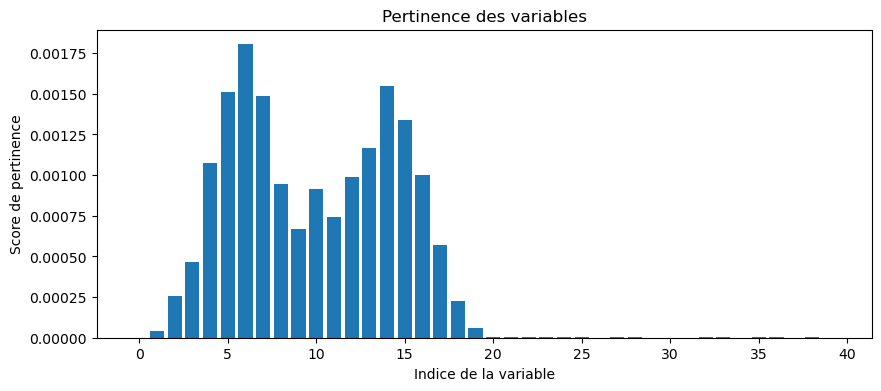

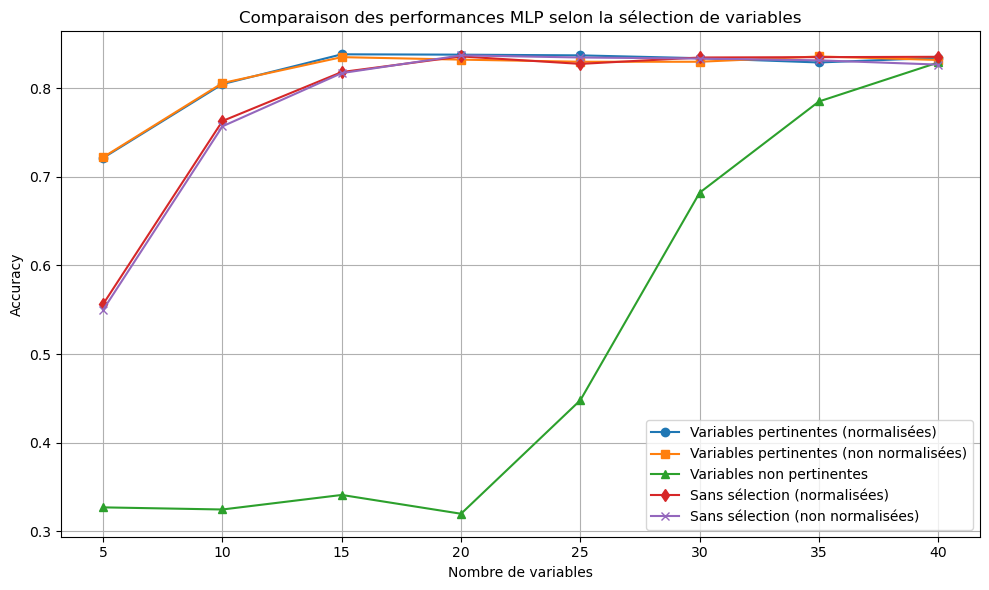

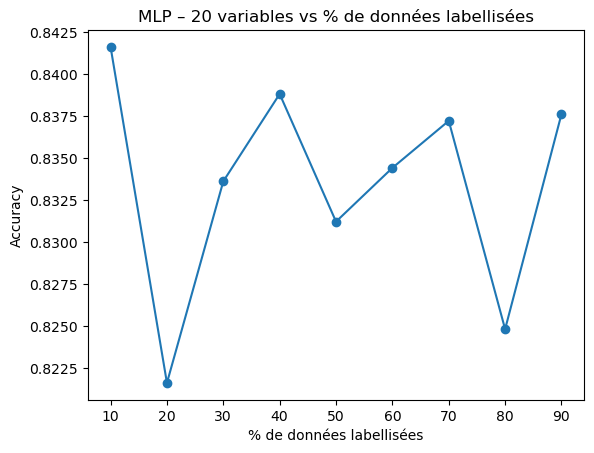

In [14]:
pipeline_evaluation("Wave.txt")